In [1]:
from typing import Callable

In [2]:
from cpa_utils import *

# Elisabeth-b4 - Filter block

## Attacking the filter S-boxes

In [3]:
traces_path = "..\\acquisition\\carto_eB4-Rnd-3-WhiteningAndFullFilter-1_key_256000_samples\\carto_eB4-Rnd-3-WhiteningAndFullFilter.mat"
key_path = "..\\acquisition\\carto_eB4-Rnd-3-WhiteningAndFullFilter-1_key_256000_samples\\carto_eB4-Rnd-3-WhiteningAndFullFilter.log"
locations_path = "correlation_locations_b4_two_last_rounds.pic"

In [4]:
seeds, traces, real_keys, sbox_output_locations = load_data(traces_path, key_path, locations_path)

In [5]:
with open("correlation_locations_b4_two_last_rounds_hw_x_i.pic", "rb") as r:
    hw_x_i_locations = pic.load(r)

In [6]:
def multiple_locations_and_hypotheses(funs_hypotheses: List[Callable], key_target_idx: int, total_seeds: np.ndarray, total_traces: np.ndarray, locations: List[np.ndarray]) -> Tuple[np.ndarray, np.ndarray]:
    location_mask_per_trace = np.zeros(total_traces.shape + (len(funs_hypotheses),), dtype=bool)
    hypotheses = np.zeros(total_seeds.shape + (len(funs_hypotheses), 16), dtype=int)

    for i, iv in enumerate(total_seeds):
        indices, whitening = chacha_random_b4(iv)
        keyround_target_idx = indices.index(key_target_idx)
        if keyround_target_idx < KEYROUND_WIDTH_B4:
            round_idx = keyround_target_idx // BLOCK_WIDTH_B4
            block_idx = keyround_target_idx % BLOCK_WIDTH_B4

            if round_idx != KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4 - 1 and round_idx != KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4 - 2:
                continue
    
            for l, fun_hypo in enumerate(funs_hypotheses):
                for k in range(16):
                    hyp = fun_hypo(round_idx, block_idx, k, whitening)
                    if hyp is not None:
                        hypotheses[i, l, k] = hyp
                        location_mask_per_trace[i, locations[l][round_idx][block_idx], l] = True

    return [total_traces[location_mask_per_trace[:, :, m]].reshape((-1, locations[m].shape[2])) for m in range(location_mask_per_trace.shape[2])], [np.moveaxis(hypotheses[np.any(location_mask_per_trace[:, :, m], axis=1), m], 1, 0) for m in range(hypotheses.shape[1])]

In [7]:
def hyp_even_sbox_output(round_idx: int, block_idx: int, k: int, whitening: List[int]) -> int:
    return HW[s_boxes_b4[block_idx][(k + whitening[round_idx * BLOCK_WIDTH_B4 + block_idx]) % 16]]

In [8]:
def hyp_hw_x_i(round_idx: int, block_idx: int, k: int, whitening: List[int]) -> int:
    return HW[(k + whitening[round_idx * BLOCK_WIDTH_B4 + block_idx]) % 16]

Key 0: 


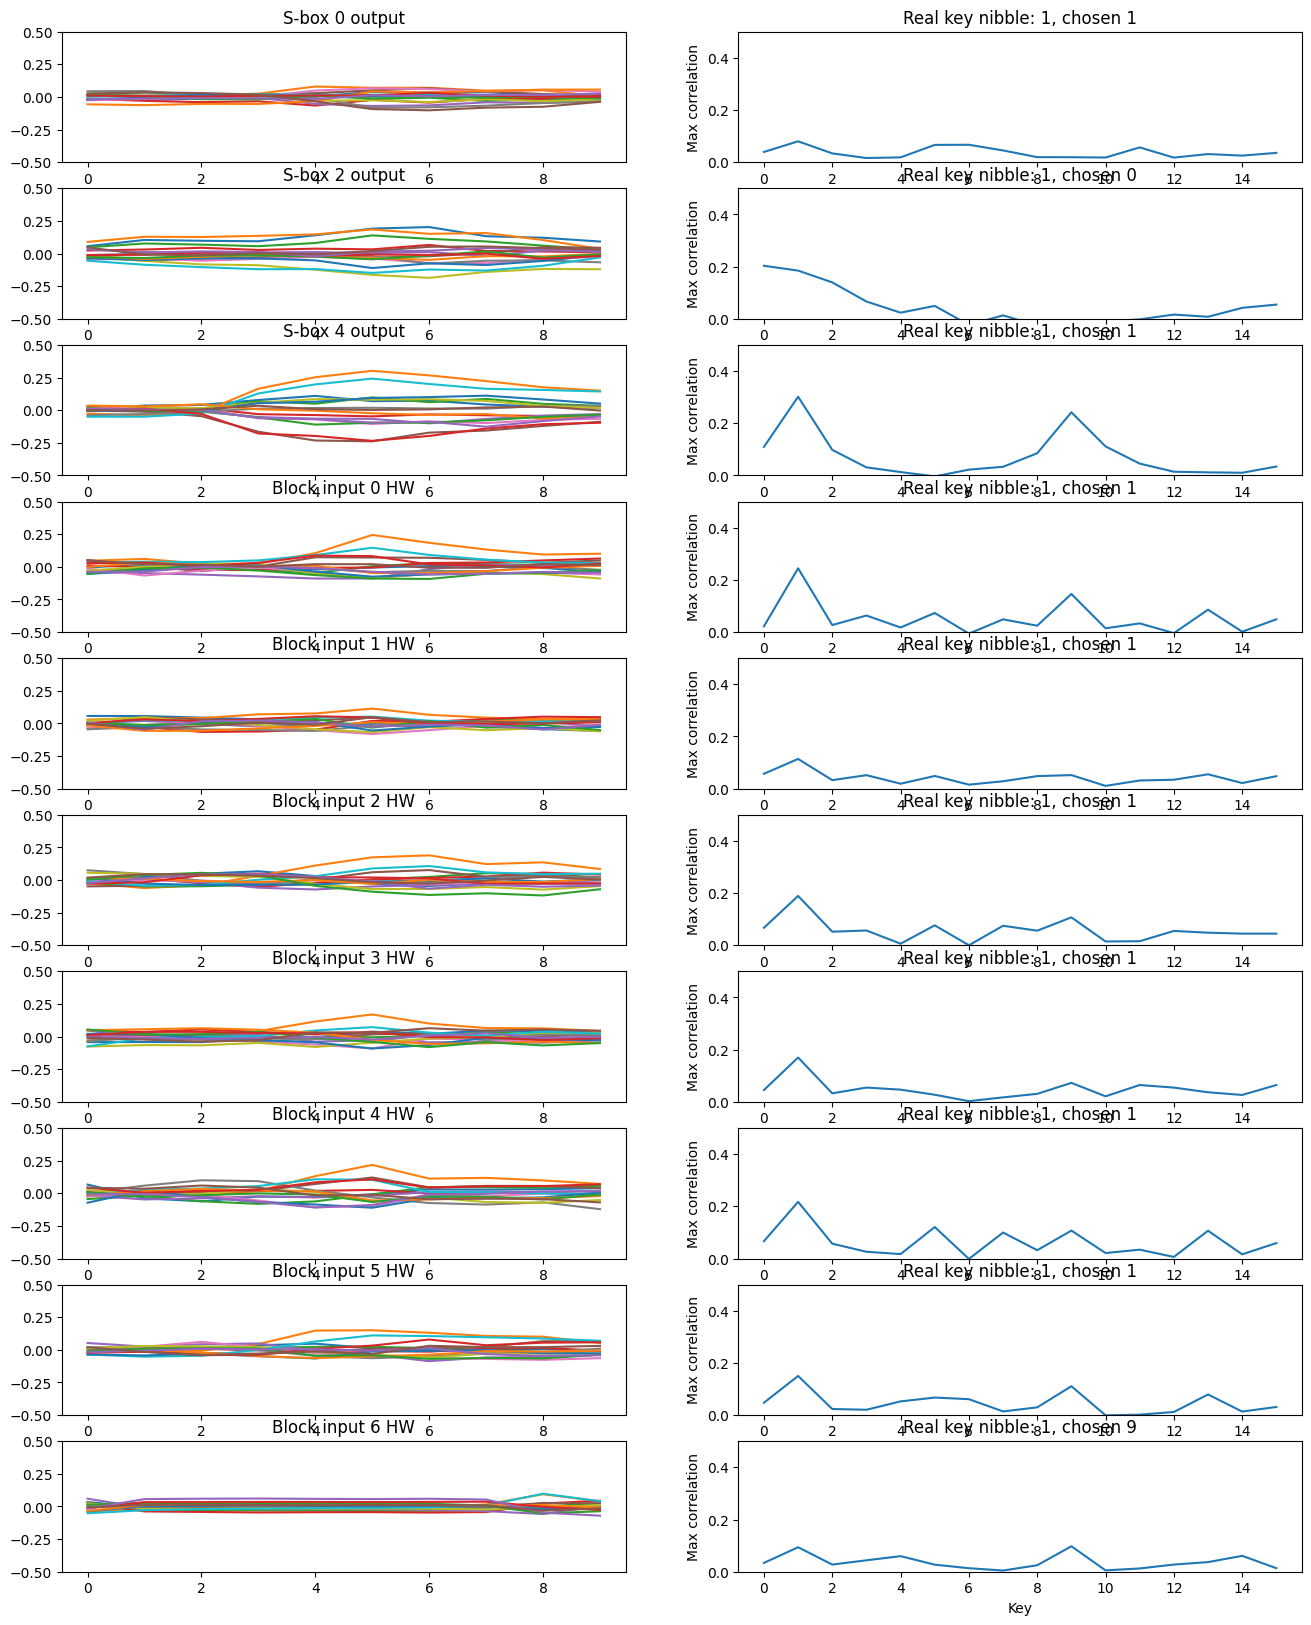

Chosen 1


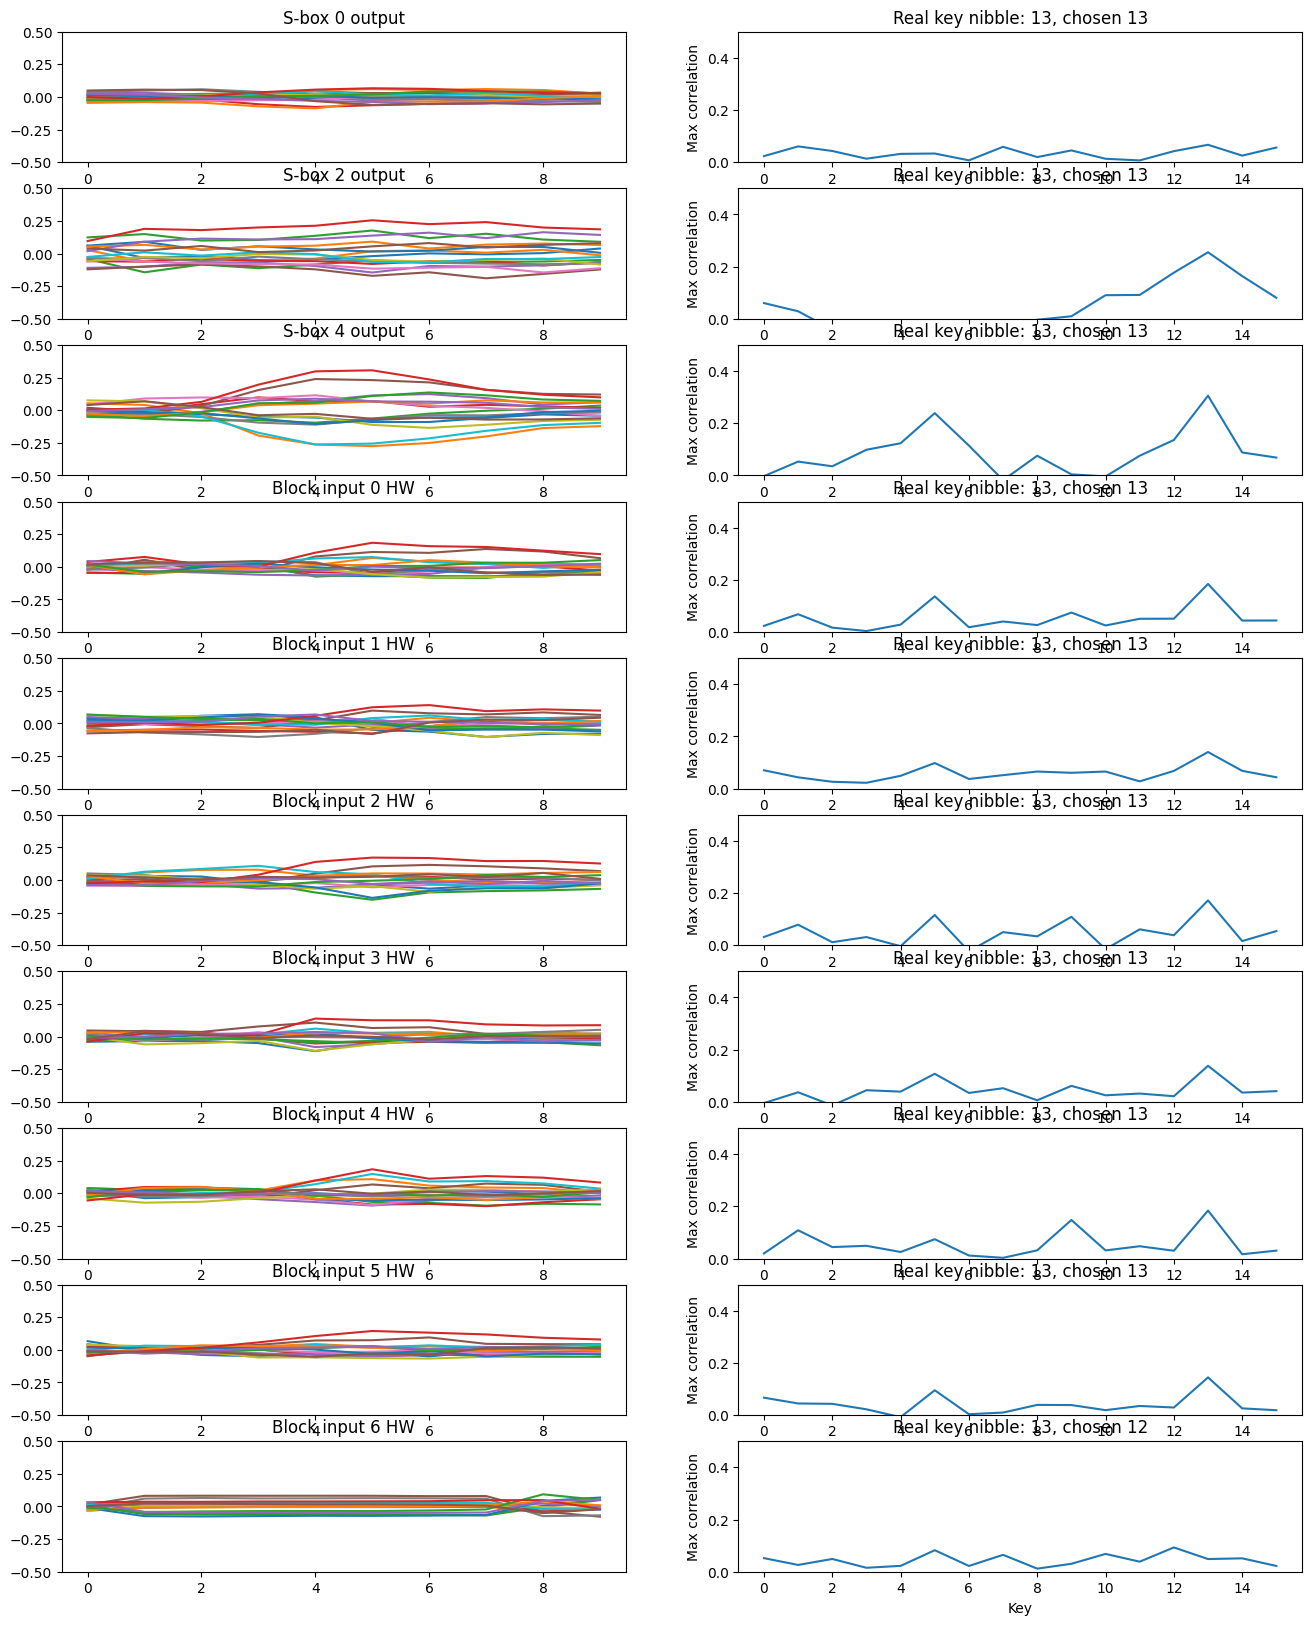

Chosen 13


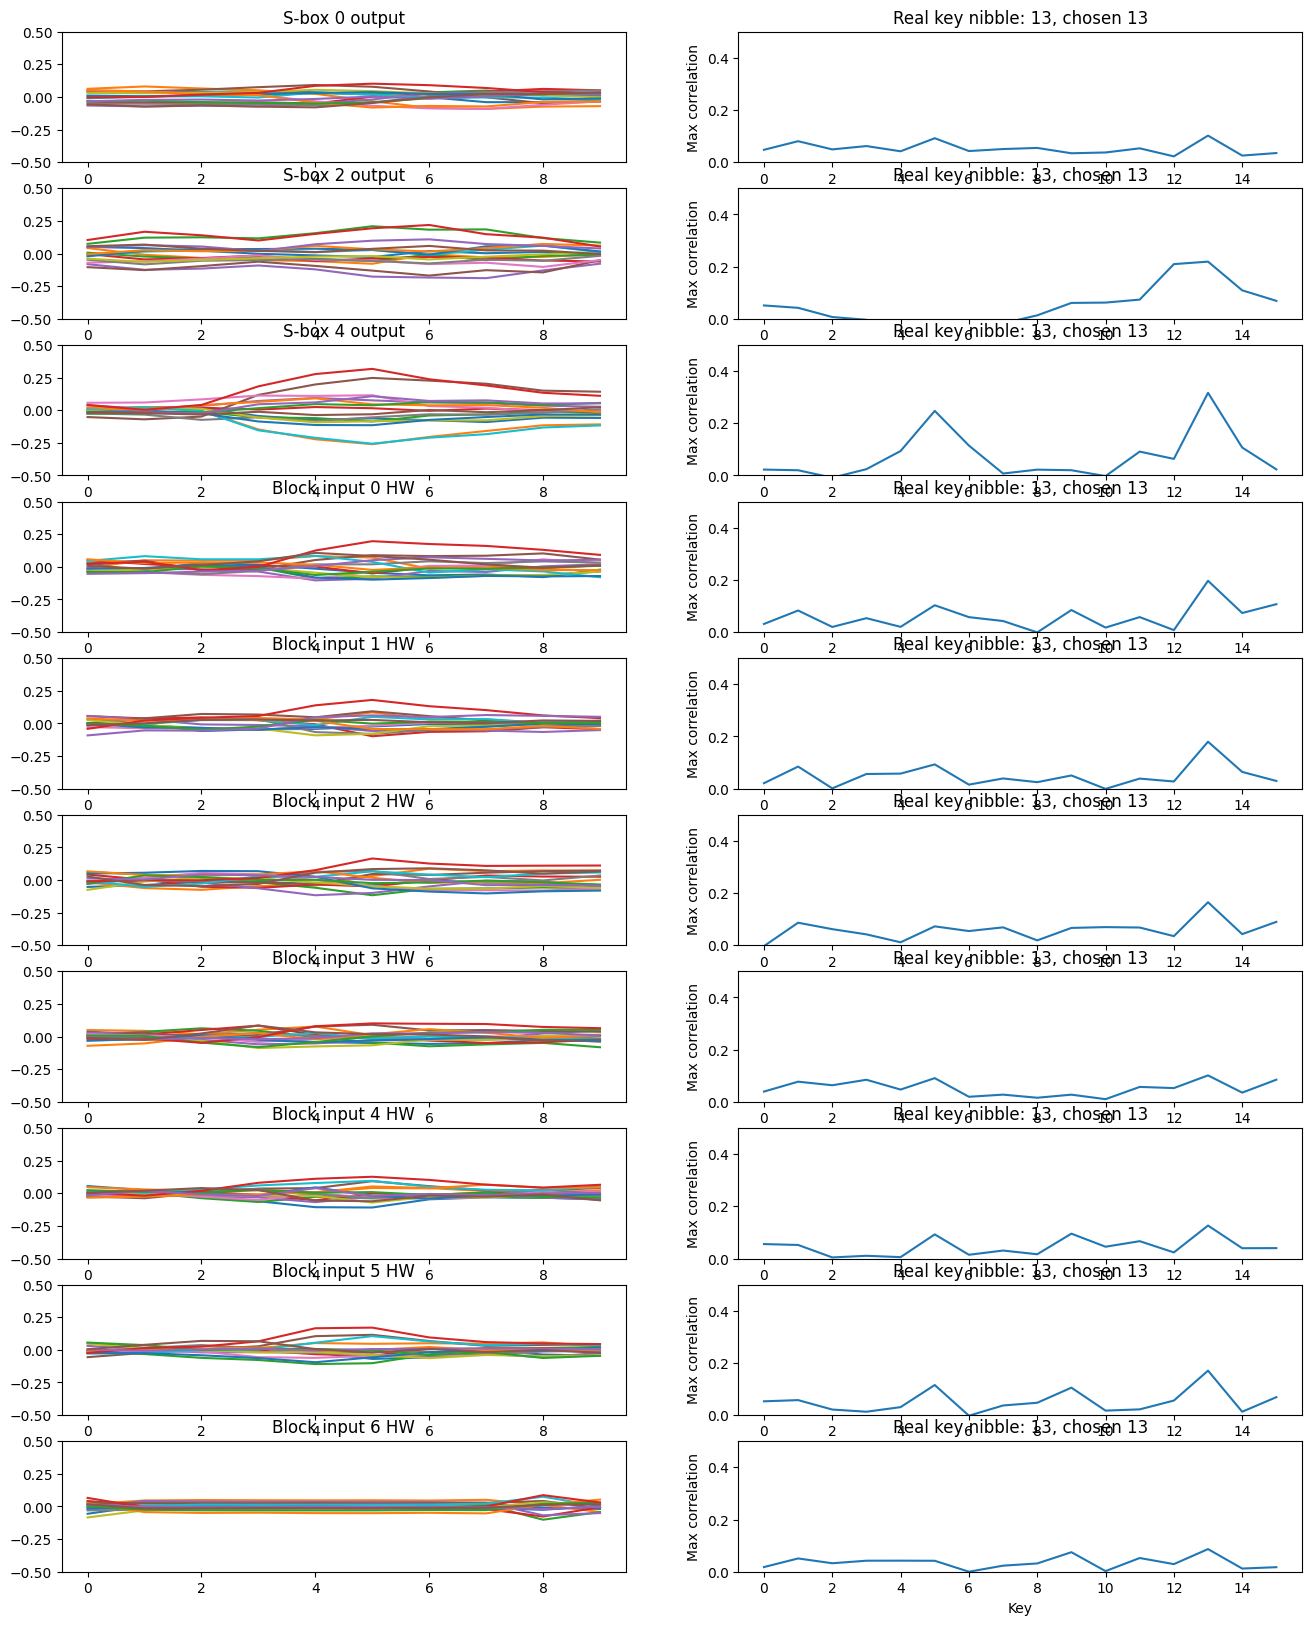

Chosen 13


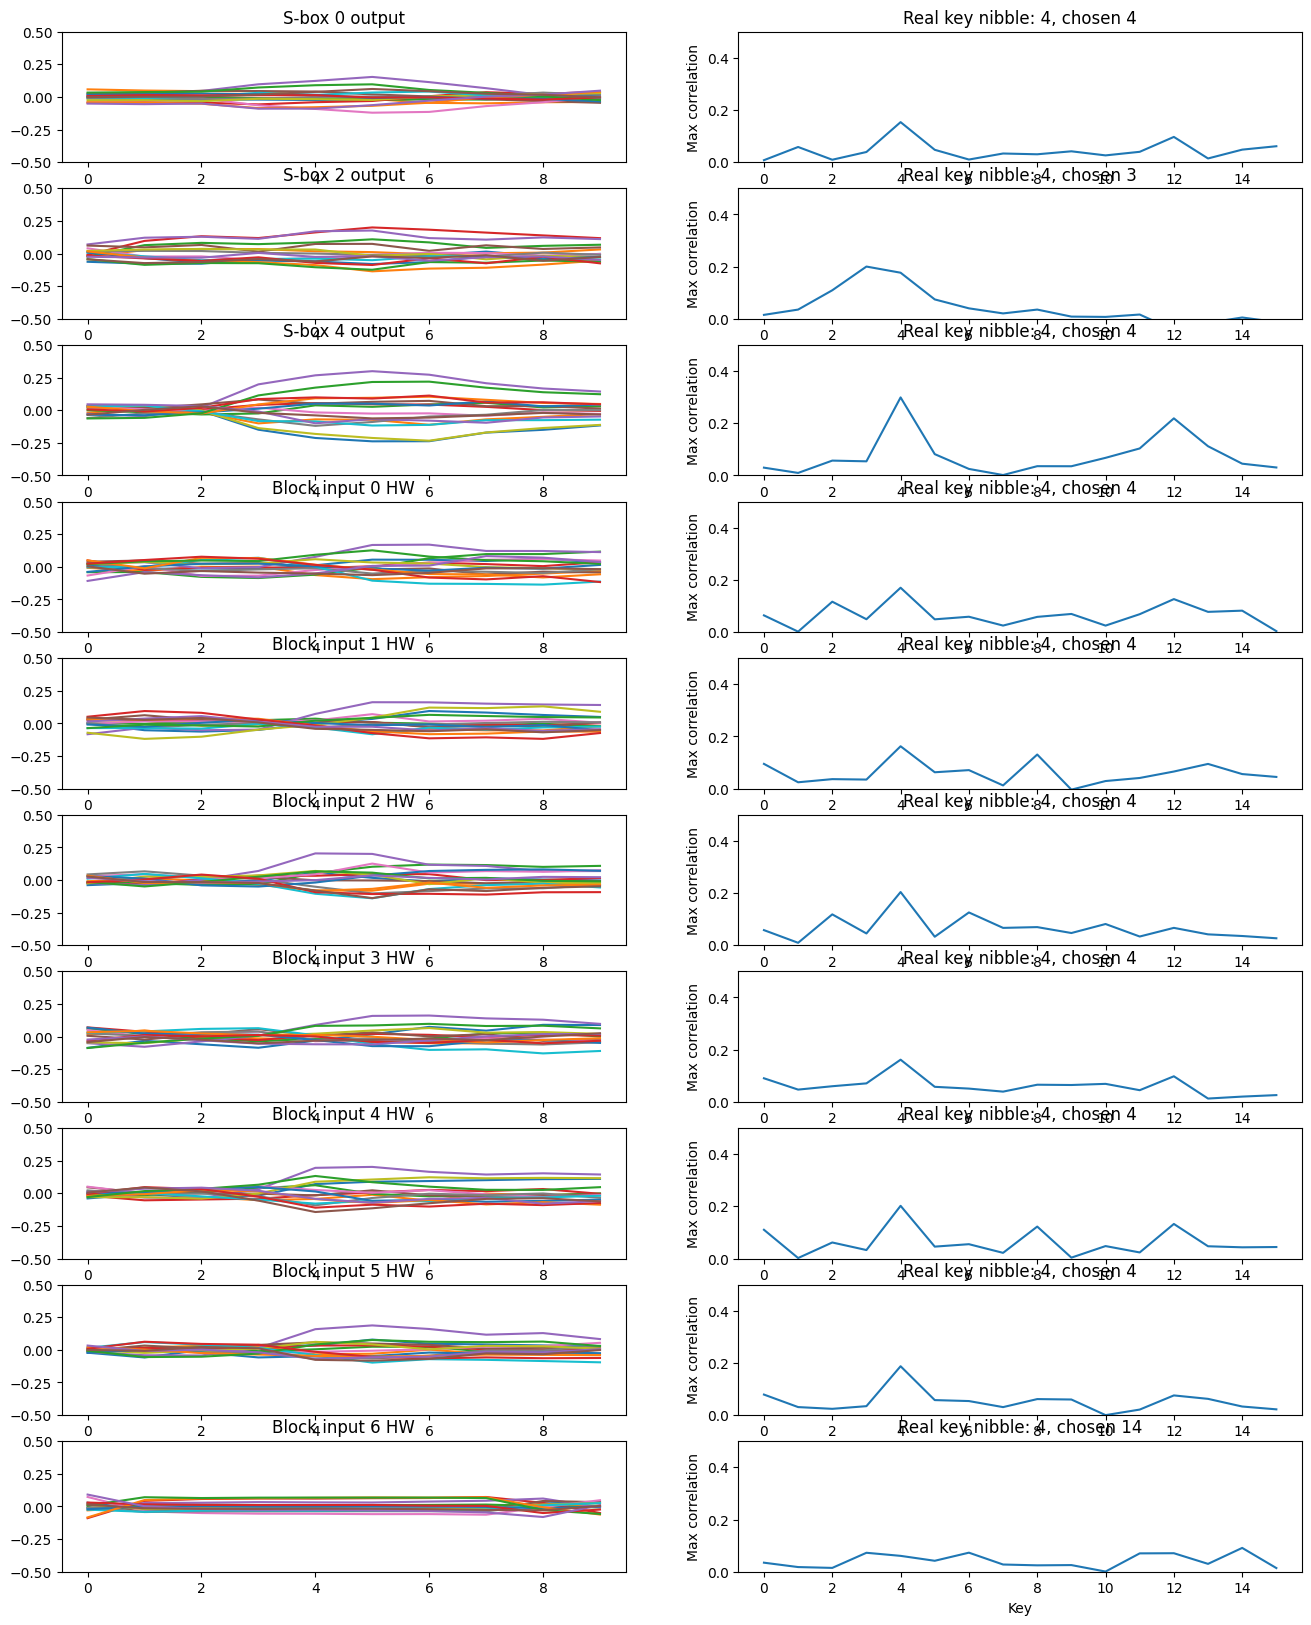

Chosen 4


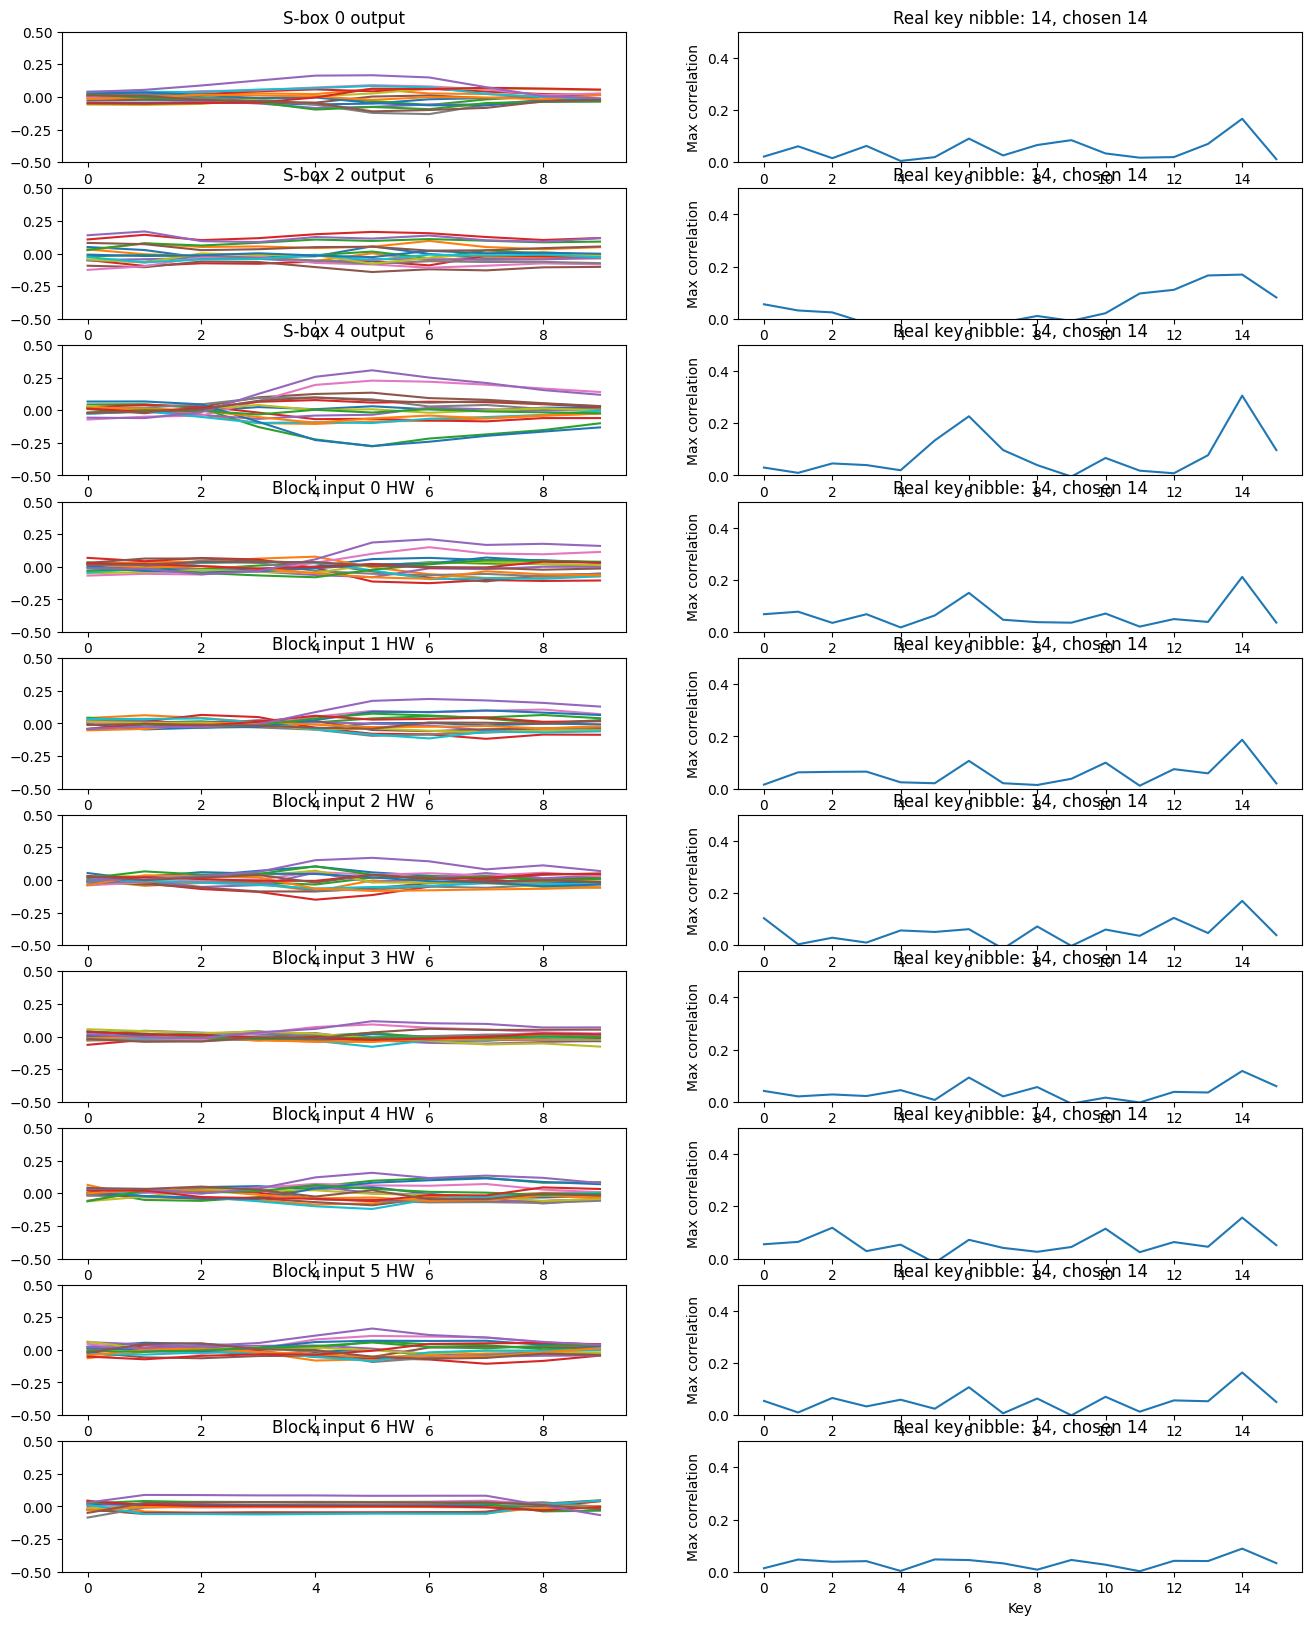

Chosen 14


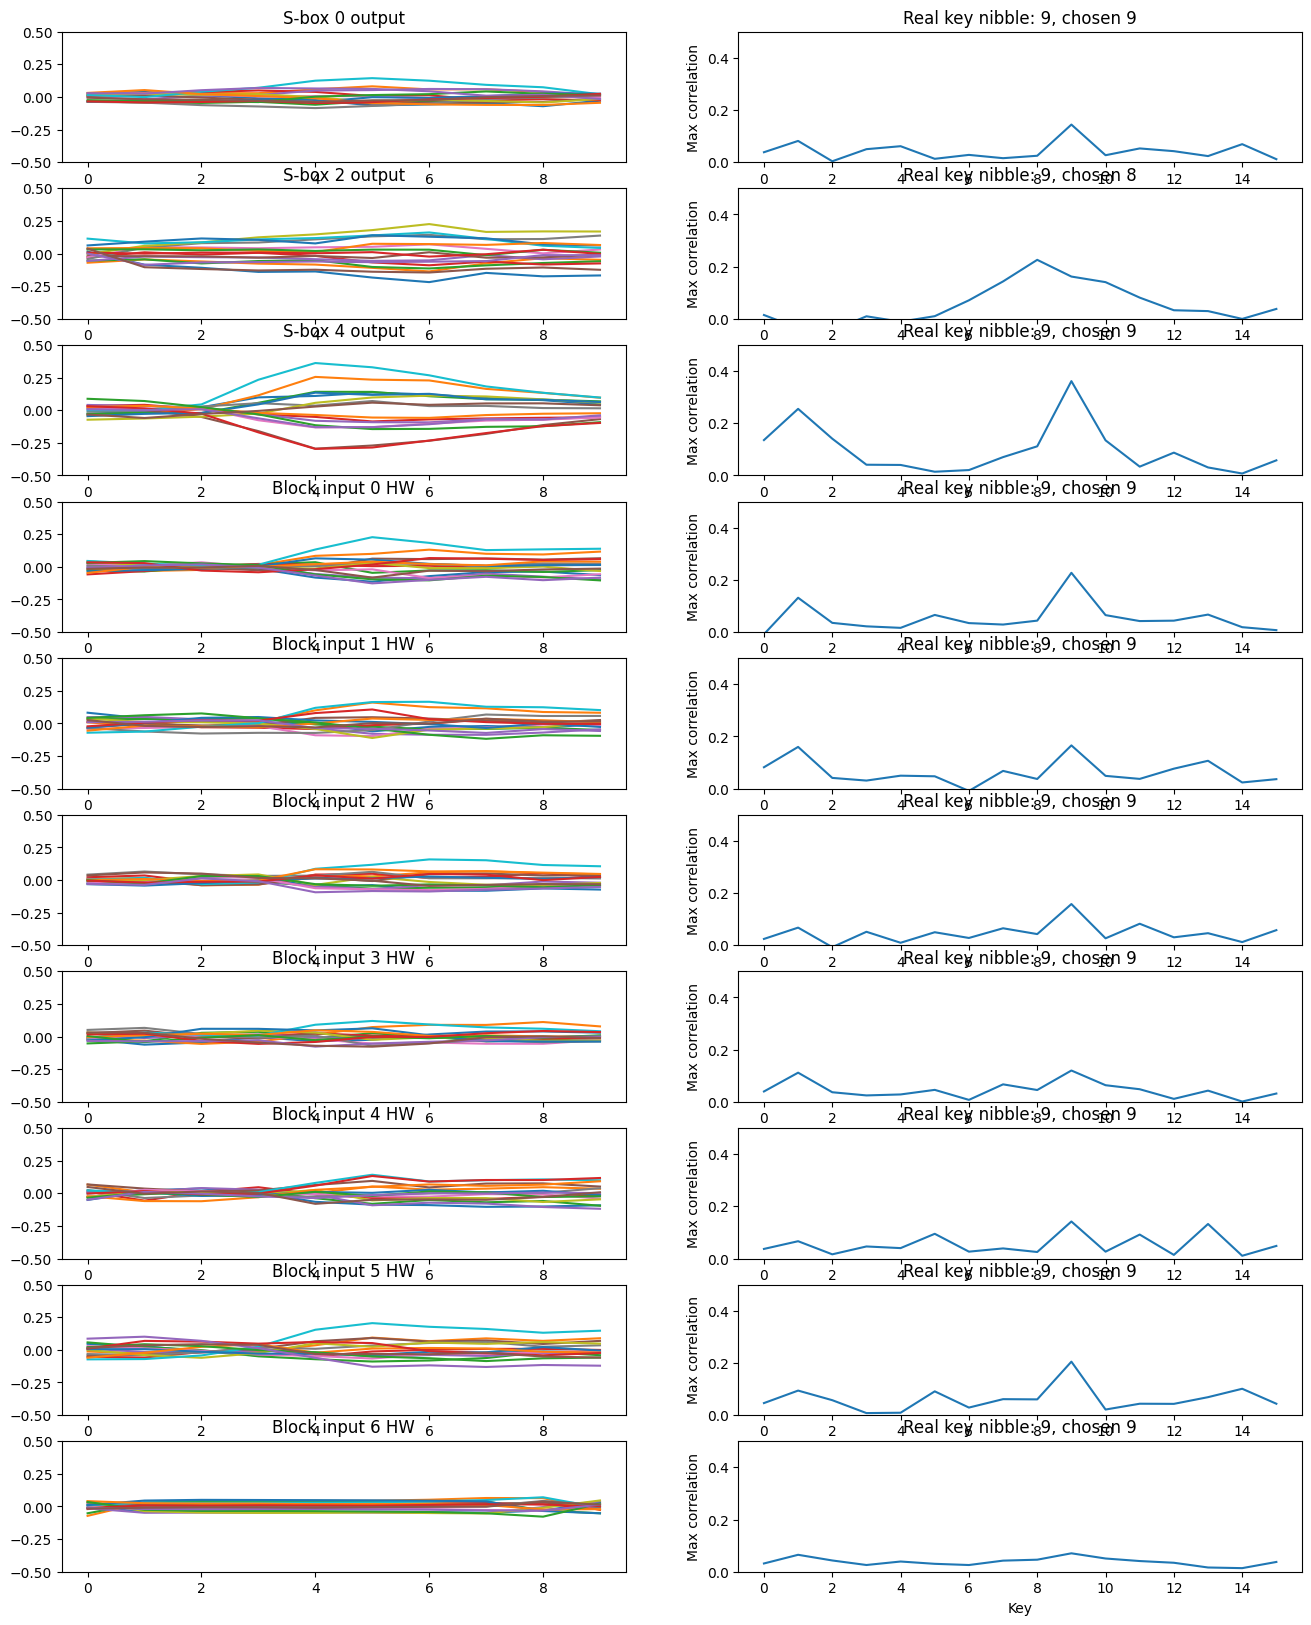

Chosen 9


In [9]:
hypotheses_funs = [lambda round_idx, block_idx, k, whitening, b=b: hyp_even_sbox_output(round_idx, block_idx, k, whitening) if b == block_idx else None for b in (0, 2, 4)] + [lambda round_idx, block_idx, k, whitening, b=b: hyp_hw_x_i(round_idx, block_idx, k, whitening) if b == block_idx else None for b in range(BLOCK_WIDTH_B4)]
hypotheses_names = [f"S-box {b} output" for b in (0, 2, 4)] + [f"Block input {b} HW" for b in range(BLOCK_WIDTH_B4)]
hypotheses_locations = [sbox_output_locations] * len((0, 2, 4)) + [hw_x_i_locations] * len(range(BLOCK_WIDTH_B4))
assert len(hypotheses_funs) == len(hypotheses_names) == len(hypotheses_locations)

reconstructed_keys = np.zeros_like(real_keys)
for i in range(reconstructed_keys.shape[0]):
    print(f"Key {i}: ")
    for j in range(reconstructed_keys.shape[1]):
        list_selected_traces, list_hypotheses = multiple_locations_and_hypotheses(hypotheses_funs, j, seeds[i], traces[i], hypotheses_locations)
        corrs = np.array([[corr_coef_vectorized(hypotheses[l], selected_traces) for l in range(hypotheses.shape[0])] for selected_traces, hypotheses in zip(list_selected_traces, list_hypotheses)])

        fig, axs = plt.subplots(corrs.shape[0], 2, figsize=(16, 20))
        if corrs.shape[0] == 1:
            axs = axs[np.newaxis, :]
        for k in range(corrs.shape[0]):
            for l in range(corrs.shape[1]):
                axs[k, 0].plot(corrs[k][l], label=str(l))

            axs[k, 0].set_ylim([-0.5, 0.5])
            axs[k, 0].set_title(hypotheses_names[k])
            
        max_corrs = np.max(corrs, axis=2)
        best_k_per_hyp = np.argmax(max_corrs, axis=1)
        if True:
            mean_corrs = np.mean(max_corrs, axis=0)
            best_k = np.argmax(mean_corrs) # Correlation mean
        else:
            best_k = Counter(best_k_per_hyp).most_common(1)[0][0] # Majority voting
        reconstructed_keys[i][j] = best_k

        for k in range(max_corrs.shape[0]):
            axs[k, 1].plot(max_corrs[k])
            axs[k, 1].set_xlabel("Key")
            axs[k, 1].set_ylabel("Max correlation")
            axs[k, 1].set_title(f"Real key nibble: {real_keys[i][j]}, chosen {best_k_per_hyp[k]}")
            axs[k, 1].set_ylim([0, 0.5])
        plt.show()
        print(f"Chosen {best_k}")

    print()
    print(f"    vs {"".join([hex(k)[2:].upper() for k in real_keys[i]])}")
    print(f"{len(real_keys[i][real_keys[i] != reconstructed_keys[i]])} mistakes on {len(real_keys[i])} nibbles.")
    print()